This is a python version of the R notebook : https://www.kaggle.com/oxzplvifi/tabular-denoising-residual-network
Please don't forget to upvote :-)
And congrats Oscar Villarreal Escamilla.
*As I don't know R language, I hope it will be accurate enough.*
I made some small changes from original, such as the batch_size, rounds, ...

The NN has 3 inputs and a residual block :
* 1. Quantile inputs
* 1. Bins inputs
* 1. Denoised + PCA inputs

*For comparison purpose, I try to keep the same files names as much as possible.
Some R functions have no exact equivalent functions in Python (as far as I know) so there are some functions definition and workaround.

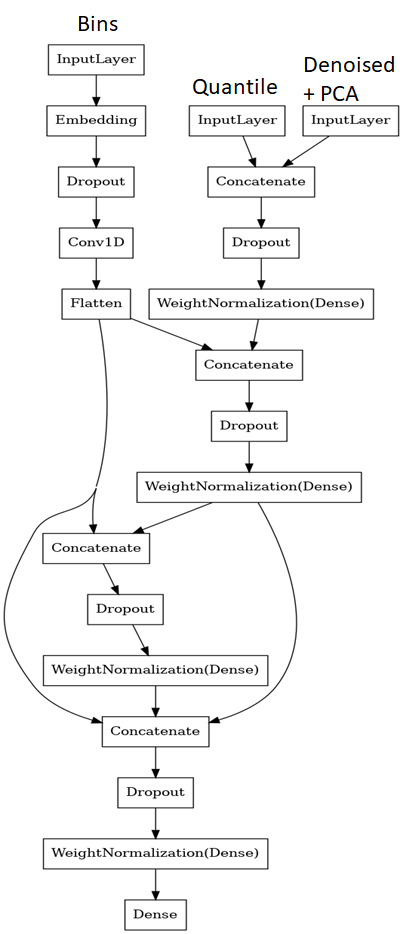

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.models import Model

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import StandardScaler,scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import numpy as np 
import pandas as pd
import math
import random
import sys
import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(keras.__version__)

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv')
test = pd.read_csv("../input/tabular-playground-series-aug-2021/test.csv")

In [ ]:
train.drop(['id'],axis = 1, inplace = True)
test.drop(['id'],axis = 1, inplace = True)
y = np.array(train['loss'])
X = train.drop(['loss'],axis = 1)
xall = pd.concat([X,test],axis=0,copy=False).reset_index(drop=True)
y.shape,X.shape,test.shape,xall.shape

<h2> Quantile Normalization

In [ ]:
xmedian = pd.DataFrame.median(xall,0)
x25quan = xall.quantile(0.25,0)
x75quan = xall.quantile(0.75,0)
xall = (xall-xmedian)/(x75quan-x25quan)

In [ ]:
def quantile_norm(df_input):
    sorted_df = pd.DataFrame(np.sort(df_input.values,axis=0), index=df_input.index, columns=df_input.columns)
    mean_df = sorted_df.mean(axis=1)
    mean_df.index = np.arange(1, len(mean_df) + 1)
    quantile_df =df_input.rank(axis = 0, method="min").stack().astype(int).map(mean_df).unstack()
    return(quantile_df)

qall = np.array(quantile_norm(xall))
qlabeled = qall[:len(train),:]
qunlabeled = qall[len(train):,:]

<h2> Simple bins creation

In [ ]:
# 100 bins for the bins head of the NN :
ball = np.zeros((qall.shape[0],X.shape[1]))
for i in range(X.shape[1]):
    ball[:,i] = pd.qcut(qall[:,i],X.shape[1],labels=False,duplicates = 'drop')
blabeled = ball[:X.shape[0],:]
bunlabeled = ball[X.shape[0]:,:]

<h2> Denoiser AutoEncoder

In [ ]:
noise = np.random.normal(0, .1, (qall.shape[0],qall.shape[1]))
qall = np.array(qall)
xnoisy = qall + noise
limit = np.int(0.8 * qall.shape[0])
# Split 80% training / 20% validation sets:
xtrain = xnoisy[0:limit,:]
ytrain = qall[0:limit,]
xvalid = xnoisy[limit:qall.shape[0],:]
yvalid = qall[limit:qall.shape[0],:]
xtrain.shape, ytrain.shape, xvalid.shape, yvalid.shape

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss',
    min_delta=1e-9, 
    patience=20, 
    verbose=0,
    mode='min', 
    baseline=None, 
    restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.8, 
    patience=4, 
    verbose=0,
    mode='min')

In [ ]:
def custom_loss(y_true, y_pred):
    loss = K.mean(K.square(y_pred - y_true))
    return loss

In [ ]:
def autoencoder():
    ae_input = layers.Input(shape = (qall.shape[1]))
    ae_encoded = layers.Dense(
        units = qall.shape[1],
        activation ='elu')(ae_input)
    ae_encoded = layers.Dense(
        units = qall.shape[1]*3,
        activation='elu')(ae_encoded)
    ae_decoded = layers.Dense(
        units = qall.shape[1],
        activation='elu')(ae_encoded)
    
    return Model(ae_input, ae_decoded),Model(ae_input,ae_encoded)

In [ ]:
autoencoder,encoder = autoencoder()
autoencoder.compile(loss= custom_loss,
                    optimizer = keras.optimizers.Adam(lr=5e-3))
history = autoencoder.fit(xtrain,
                    ytrain, 
                    epochs = 200,
                    batch_size = 512,
                    verbose = 0,
                    validation_data=(xvalid,yvalid),
                    callbacks=[es,plateau])

In [ ]:
eall = encoder.predict(qall) # data encoding by denoiser encoder
print("max encoded value =",np.max(eall)) # check if the denoising was successful for variance

<h2> Features encoded selection according to variance threshold

In [ ]:
evar = np.var(eall, axis=0,ddof=1)
evar1 = evar > 0.8  # Threshold variance
a = np.where(evar1 == False,evar1,1)
nb_col = a.sum()
print("number of selected columns",nb_col)
if ((nb_col < 95) | (nb_col > 110)) == True:
    sys.exit()  # Stop in case of a too small or too large number of features selected
eall_1 = pd.DataFrame()
for i in range(qall.shape[1]*3):
    if evar1[i] == True:
        colname = f'col_{i}'
        eall_1[colname] = eall[:,i]
eall_1 = np.array(eall_1)
elabeled = eall_1[:len(train),:]
eunlabeled = eall_1[len(train):,:]
elabeled.shape,eunlabeled.shape

<h2> PCA on encoded features

In [ ]:
pca = PCA(n_components=10)
pall = pca.fit_transform(eall)
sc_pca = StandardScaler()
pall = sc_pca.fit_transform(pall)

<h2>Merge of PCA + encoded features (after threshold)

In [ ]:
plabeled = pall[:len(train),:]
punlabeled = pall[len(train):,:]
elabeled = np.hstack((elabeled,plabeled))
eunlabeled = np.hstack((eunlabeled,punlabeled))

<h2> NN Model definition

In [ ]:
def get_res_model():
    
    # Quantile-normalized input:
    inputQ = layers.Input(shape = (qall.shape[1]))

    # Encoded + principal components input:
    inputE = layers.Input(shape= (elabeled.shape[1]))

    # Quantile-binned input:
    inputB = layers.Input(shape = (blabeled.shape [1]))
    
    # Feed-forward block:
    denseQE = layers.Dropout(0.3)(layers.Concatenate()([inputQ,inputE]))
    denseQE = tfa.layers.WeightNormalization(
                layers.Dense(
                units = 300,
                activation='elu',
                kernel_initializer = "lecun_normal"))(denseQE) 
    
   # Embedding + convolutional block:
    embedB = layers.Embedding (input_dim = blabeled.shape [1]+1, 
                              output_dim = 6,
                              embeddings_regularizer='l2',
                              embeddings_initializer='lecun_uniform')(inputB)
    embedB = layers.Dropout(0.3)(embedB)
    embedB = layers.Conv1D(6,1,activation = 'relu')(embedB)
    embedB = layers.Flatten()(embedB)
    
    # Residual block:
    hidden = layers.Dropout(0.3)(layers.Concatenate()([denseQE,embedB]))
    hidden = tfa.layers.WeightNormalization(
                layers.Dense(
                units = 64,
                activation='elu',
                kernel_initializer = "lecun_normal"))(hidden) 
    
    output = layers.Dropout(0.3)(layers.Concatenate()([embedB,hidden]))
    output = tfa.layers.WeightNormalization(
                layers.Dense(
                units = 32,
                activation='relu',
                kernel_initializer = "lecun_normal"))(output) 
    
    output = layers.Dropout(0.4)(layers.Concatenate()([embedB,hidden,output]))
    output = tfa.layers.WeightNormalization(
                layers.Dense(
                units = 32,
                activation='selu',
                kernel_initializer = "lecun_normal"))(output) 
    output = layers.Dense(
                units = 1, 
                activation ='selu',
                kernel_initializer ="lecun_normal")(output)
    # Output:
    model = Model([inputQ,inputE,inputB],output)
    model.compile(loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()],
                  optimizer = keras.optimizers.Adam(lr=0.005))
    
    return model

<h2> Training & prediction

In [ ]:
N_FOLDS = 10
SEED = 1
EPOCH = 100
N_round = 5

oof = np.zeros((y.shape[0],1))
pred = np.zeros((test.shape[0],1))

for i in range (N_round):
    
    oof_round = np.zeros((y.shape[0],1))
    skf = StratifiedKFold(n_splits=N_FOLDS, 
                          shuffle=True, 
                          random_state=SEED *i
                         )

    for fold, (tr_idx, ts_idx) in enumerate(skf.split(X,y)):
        print(f"\n------ TRAINING ROUND {i} FOLD {fold} ------\n")
        
        # Normalized:
        qtrain = qlabeled[tr_idx]                       
        qvalid = qlabeled[ts_idx]
        
        # Binned:
        btrain = blabeled[tr_idx]
        bvalid = blabeled[ts_idx]
        
        # Encoded:
        etrain = elabeled[tr_idx]
        evalid = elabeled[ts_idx]
        
        # target:
        ytrain = y[tr_idx]
        yvalid = y[ts_idx]
 
        K.clear_session()

        #================= MODEL training =========

        model= get_res_model()
        model.fit([qtrain, etrain, btrain],
                  ytrain,
                  batch_size = 2048, 
                  epochs = EPOCH,
                  validation_data=([qvalid, evalid, bvalid],
                  yvalid),
                  callbacks=[es, plateau],
                  verbose = 0)

        #============== Model prediction ==========
        
        pred_round = model.predict([qvalid, evalid, bvalid]) 
        oof[ts_idx] += pred_round / N_round
        oof_round[ts_idx] += pred_round
        pred += model.predict([qunlabeled, eunlabeled, bunlabeled]) / (N_FOLDS * N_round)
        
    score_round = math.sqrt(mean_squared_error(y, oof_round))
    print(f"==== SCORE round {i}: {score_round} ====\n")
    
score_round = math.sqrt(mean_squared_error(y, oof))
print(f"\n***** FINAL SCORE MODEL : {score_round} *****\n") 

In [ ]:
sample_submission = pd.read_csv("../input/tabular-playground-series-aug-2021/sample_submission.csv")
sample_submission['loss'] = pred
pd.DataFrame(oof).to_csv('oof_2.csv',index = False)
sample_submission.to_csv('submission_v2.csv',index = False)
display(pd.read_csv("submission_v2.csv"))